## SVHN Modelling

In [1]:
%load_ext watermark

%watermark -a 'P.S. Aravind' -u -n -t -z -v -m -p numpy,scipy,matplotlib,tensorflow

P.S. Aravind 
last updated: Sun Oct 16 2016 23:48:32 UTC

CPython 2.7.6
IPython 4.1.1

numpy 1.11.2
scipy 0.13.3
matplotlib 1.5.1
tensorflow 0.11.0rc0

compiler   : GCC 4.8.2
system     : Linux
release    : 4.4.20-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


### Import python packages needed for analysis

In [2]:
import numpy as np
import tensorflow as tf
import random
import gzip
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

### Load compressed pickle files for Train, Validation and Test

In [3]:
pickle_file = './data/SVHN_train1.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_train1 = save['X_train1']
  y_train1 = save['y_train1']
  del save

pickle_file = './data/SVHN_train2.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_train2 = save['X_train2']
  y_train2 = save['y_train2']
  del save
    
pickle_file = './data/SVHN_train3.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_train3 = save['X_train3']
  y_train3 = save['y_train3']
  del save
    
pickle_file = './data/SVHN_train4.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_train4 = save['X_train4']
  y_train4 = save['y_train4']
  del save
    
X_train = np.concatenate(([X_train1, X_train2, X_train3, X_train4]))
y_train = np.concatenate(([y_train1, y_train2, y_train3, y_train4]))

del X_train1, X_train2, X_train3, X_train4
del y_train1, y_train2, y_train3, y_train4

In [4]:
pickle_file = './data/SVHN_valid.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_valid = save['X_valid']
  y_valid = save['y_valid']
  del save
    
pickle_file = './data/SVHN_test.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_test = save['X_test']
  y_test = save['y_test']
  del save

In [5]:
print('Train Data shape:', X_train.shape)
print('Train Labels shape:', y_train.shape)
print('Valid Data shape:', X_valid.shape)
print('Valid Labels shape:', y_valid.shape)
print('Test Data shape:', X_test.shape)
print('Test Labels shape:', y_test.shape)

('Train Data shape:', (188604, 32, 32, 1))
('Train Labels shape:', (188604, 7))
('Valid Data shape:', (47151, 32, 32, 1))
('Valid Labels shape:', (47151, 7))
('Test Data shape:', (13068, 32, 32, 1))
('Test Labels shape:', (13068, 7))


### Metric to evaluate perfromance of the model

Computes proportion of the images for which the length n of the sequence and every element of the sequence is predicted correctly. Returns the accuracy value for the entire dataset.

In [6]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [7]:
image_size = 32 # parametrized to change input image size
labels = 11 # number of lables 0-9, 10 for space
channels = 1 # number of input channels, 1 for grey scale

# creates and runs model with different parameters
# Input:
#    batch_size - configurable batch size for running the model
#    keep_prob - probability that each element is kept in that layer
#    starter_learning_rate - learning rate applied to optimizer
#    steps - number of iterations over the training set
#    log_steps - steps to print out accuracy
# Returns:
#   y_test_prediction - prediction for the test dataset
def run_model(batch_size, keep_prob, starter_learning_rate, steps, log_steps):
    patch_size = 5 # patch size
    channels1 = 16 # input channel size
    channels2 = 32 # input/output channel size subsequent layers
    channels3 = 64 # input/output channel size subsequent layers
    channels4 = 128 # input/output channel size subsequent layers
    
    shape = [batch_size, image_size, image_size, channels]
    graph = tf.Graph()
    
    # setup placeholders for train, valid and test
    # setup weights and biases for each layer
    with graph.as_default():
        # setup placeholders for train, valid and test
        # setup weights and biases for each layer
        
        tf_X_train = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, channels))
        tf_y_train = tf.placeholder(tf.int32, shape=(batch_size, 7))
        tf_X_valid = tf.constant(X_valid)
        tf_X_test = tf.constant(X_test)
        
        W1 = tf.get_variable('W1', 
                            shape=[patch_size, patch_size, channels, channels1],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        W2 = tf.get_variable('W2', 
                            shape=[patch_size, patch_size, channels1, channels2],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        W3 = tf.get_variable('W3', 
                            shape=[patch_size, patch_size, channels2, channels3],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        W4 = tf.get_variable('W4', 
                            shape=[patch_size, patch_size, channels3, channels4],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())        
        
        b1 = tf.Variable(tf.constant(1.0, shape=[channels1]), name='b1')
        b2 = tf.Variable(tf.constant(1.0, shape=[channels2]), name='b2')
        b3 = tf.Variable(tf.constant(1.0, shape=[channels3]), name='b3')
        b4 = tf.Variable(tf.constant(1.0, shape=[channels4]), name='b4')
        
        Lw = tf.get_variable('Lw', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw1 = tf.get_variable('Sw1', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw2 = tf.get_variable('Sw2', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw3 = tf.get_variable('Sw3', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw4 = tf.get_variable('Sw4', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw5 = tf.get_variable('Sw5', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
                           
        Lb = tf.Variable(tf.constant(1.0, shape=[labels]), name='Lb')
        Sb1 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb1')
        Sb2 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb2') 
        Sb3 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb3')
        Sb4 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb4')
        Sb5 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb5')
        
        # Create deep neural network  and return model for length and 5 digits of the sequence
        def createModel(data, keep_prob, shape):
            h_conv1 = tf.nn.relu(tf.nn.conv2d(data, W1, [1, 1, 1, 1], 'VALID', name='h_conv1') + b1)
            lrn = tf.nn.local_response_normalization(h_conv1)
            h_drop = tf.nn.dropout(lrn, keep_prob)
            
            h_pool1 = tf.nn.max_pool(h_drop, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='h_pool1')
            h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W2, [1, 1, 1, 1], 'VALID', name='h_conv2') + b2)
            lrn = tf.nn.local_response_normalization(h_conv2)
            h_drop = tf.nn.dropout(lrn, keep_prob)
            
            h_pool2 = tf.nn.max_pool(h_drop, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='h_pool2')
            h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W3, [1, 1, 1, 1], 'VALID', name='h_conv3') + b3)
            h_drop = tf.nn.dropout(h_conv3, keep_prob)

            h_pool3 = tf.nn.max_pool(h_drop, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='h_pool3')
            h_conv4 = tf.nn.relu(tf.nn.conv2d(h_pool3, W4, [1, 1, 1, 1], 'SAME', name='h_conv4') + b4)
            h_drop = tf.nn.dropout(h_conv4, keep_prob)
            
            h_drop_shape = h_drop.get_shape().as_list()
            h_drop = tf.reshape(h_drop, [h_drop_shape[0], h_drop_shape[1] * h_drop_shape[2] * h_drop_shape[3]])
            
            L = tf.matmul(h_drop, Lw) + Lb
            S1 = tf.matmul(h_drop, Sw1) + Sb1
            S2 = tf.matmul(h_drop, Sw2) + Sb2
            S3 = tf.matmul(h_drop, Sw3) + Sb3
            S4 = tf.matmul(h_drop, Sw4) + Sb4
            S5 = tf.matmul(h_drop, Sw5) + Sb5
            
            return [L, S1, S2, S3, S4, S5]
        
        [L, S1, S2, S3, S4, S5] = createModel(tf_X_train, keep_prob, shape)
        
        # define loss function as a sum of six separate softmax classifiers each for length and 5 digits
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(L, tf_y_train[:, 0])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(S1, tf_y_train[:, 1])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(S2, tf_y_train[:, 2])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(S3, tf_y_train[:, 3])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(S4, tf_y_train[:, 4])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(S5, tf_y_train[:, 5]))
        tf.scalar_summary('loss', loss)
        
        # define stocastic gradient desent parameter
        batch = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                                   batch, 
                                                   decay_steps=10000, 
                                                   decay_rate=0.95)
        train_step = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=batch)
        
        train_prediction = tf.pack([tf.nn.softmax(L), tf.nn.softmax(S1), tf.nn.softmax(S2),
                                    tf.nn.softmax(S3), tf.nn.softmax(S4), tf.nn.softmax(S5)])
        
        [valid_L, valid_S1, valid_S2, valid_S3, valid_S4, valid_S5] = createModel(tf_X_valid, 1.0, shape)
        valid_prediction = tf.pack([tf.nn.softmax(valid_L), tf.nn.softmax(valid_S1), tf.nn.softmax(valid_S2),
                                    tf.nn.softmax(valid_S3), tf.nn.softmax(valid_S4), tf.nn.softmax(valid_S5)])
        
        [test_L, test_S1, test_S2, test_S3, test_S4, test_S5] = createModel(tf_X_test, 1.0, shape)
        test_prediction = tf.pack([tf.nn.softmax(test_L), tf.nn.softmax(test_S1), tf.nn.softmax(test_S2),
                                    tf.nn.softmax(test_S3), tf.nn.softmax(test_S4), tf.nn.softmax(test_S5)])
        
        # save model for future prediction
        save_model = tf.train.Saver()
        
        with tf.Session(graph=graph) as session:
            tf.initialize_all_variables().run()
            
            merged = tf.merge_all_summaries()
            summary_file = './logs/' + \
                str(batch_size) + '_' + \
                str(keep_prob) + '_' + \
                str(starter_learning_rate) + '_' + \
                str(steps)
                
            test_writer = tf.train.SummaryWriter(summary_file)
            
            # step through the iterations
            for step in range(steps):
                offset = (step * batch_size) % (y_train.shape[0] - batch_size)
                X_batch = X_train[offset:(offset + batch_size), :, :, :]
                y_batch = y_train[offset:(offset + batch_size), :]
                feed_dict = {tf_X_train:X_batch, tf_y_train:y_batch}
                summary, _, l, y_train_prediction = session.run([merged, train_step, loss, train_prediction], feed_dict=feed_dict)
                
                test_writer.add_summary(summary, step)
                if (step % log_steps == 0):
                    print('Minibatch loss at step %d: %f' % (step, l))
                    print('Minibatch accuracy: %.1f%%' % accuracy(y_train_prediction, y_batch[:, :6]))
                    print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), y_valid[:, :6]))
            y_test_prediction = test_prediction.eval()
            print('Test accuracy for batch size:%d, keep_prob=%.2g, starter_learning_rate=%.3g, steps=%d - %.1f%%' % \
                  (batch_size, keep_prob, starter_learning_rate, steps, accuracy(y_test_prediction, y_test[:, :6])))
            model_file = './data/' + \
                str(batch_size) + '_' + \
                str(keep_prob) + '_' + \
                str(starter_learning_rate) + '_' + \
                str(steps) + '.ckpt'
            save_path = save_model.save(session, model_file)
            print('Model saved in file: %s' % save_path)
    return y_test_prediction

In [8]:
run_model(batch_size=64, keep_prob=0.5, starter_learning_rate=0.001, steps=5000, log_steps=1000)

Minibatch loss at step 0: 20.475777
Minibatch accuracy: 10.7%
Validation accuracy: 20.7%
Minibatch loss at step 1000: 8.860516
Minibatch accuracy: 52.9%
Validation accuracy: 54.1%
Minibatch loss at step 2000: 8.850510
Minibatch accuracy: 51.3%
Validation accuracy: 54.1%
Minibatch loss at step 3000: 8.630324
Minibatch accuracy: 52.1%
Validation accuracy: 54.1%
Minibatch loss at step 4000: 8.663052
Minibatch accuracy: 51.0%
Validation accuracy: 54.1%
Test accuracy for batch size:64, keep_prob=0.5, starter_learning_rate=0.001, steps=5000 - 55.8%
Model saved in file: ./data/64_0.5_0.001_5000.ckpt


In [9]:
run_model(batch_size=64, keep_prob=0.5, starter_learning_rate=0.05, steps=5000, log_steps=1000)

Minibatch loss at step 0: 23.165756
Minibatch accuracy: 8.1%
Validation accuracy: 52.2%
Minibatch loss at step 1000: 8.065890
Minibatch accuracy: 52.6%
Validation accuracy: 54.4%
Minibatch loss at step 2000: 7.993787
Minibatch accuracy: 54.7%
Validation accuracy: 54.1%
Minibatch loss at step 3000: 8.073768
Minibatch accuracy: 52.6%
Validation accuracy: 54.4%
Minibatch loss at step 4000: 7.924681
Minibatch accuracy: 53.1%
Validation accuracy: 54.4%
Test accuracy for batch size:64, keep_prob=0.5, starter_learning_rate=0.05, steps=5000 - 56.1%
Model saved in file: ./data/64_0.5_0.05_5000.ckpt


In [10]:
run_model(batch_size=64, keep_prob=0.85, starter_learning_rate=0.05, steps=5000, log_steps=1000)

Minibatch loss at step 0: 23.456743
Minibatch accuracy: 3.6%
Validation accuracy: 52.2%
Minibatch loss at step 1000: 7.053787
Minibatch accuracy: 61.2%
Validation accuracy: 61.3%
Minibatch loss at step 2000: 4.288676
Minibatch accuracy: 78.4%
Validation accuracy: 77.6%
Minibatch loss at step 3000: 3.343428
Minibatch accuracy: 81.8%
Validation accuracy: 84.7%
Minibatch loss at step 4000: 3.328393
Minibatch accuracy: 82.3%
Validation accuracy: 87.0%
Test accuracy for batch size:64, keep_prob=0.85, starter_learning_rate=0.05, steps=5000 - 90.0%
Model saved in file: ./data/64_0.85_0.05_5000.ckpt


In [11]:
run_model(batch_size=32, keep_prob=0.9, starter_learning_rate=0.05, steps=5000, log_steps=1000)

Minibatch loss at step 0: 20.033606
Minibatch accuracy: 10.4%
Validation accuracy: 49.5%
Minibatch loss at step 1000: 7.163698
Minibatch accuracy: 56.8%
Validation accuracy: 57.9%
Minibatch loss at step 2000: 5.624270
Minibatch accuracy: 67.2%
Validation accuracy: 70.2%
Minibatch loss at step 3000: 5.086439
Minibatch accuracy: 71.4%
Validation accuracy: 78.4%
Minibatch loss at step 4000: 4.159863
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Test accuracy for batch size:32, keep_prob=0.9, starter_learning_rate=0.05, steps=5000 - 88.1%
Model saved in file: ./data/32_0.9_0.05_5000.ckpt


In [12]:
run_model(batch_size=64, keep_prob=0.9, starter_learning_rate=0.05, steps=5000, log_steps=1000)

Minibatch loss at step 0: 20.021627
Minibatch accuracy: 8.3%
Validation accuracy: 52.2%
Minibatch loss at step 1000: 6.330925
Minibatch accuracy: 63.8%
Validation accuracy: 65.7%
Minibatch loss at step 2000: 4.577037
Minibatch accuracy: 76.3%
Validation accuracy: 78.9%
Minibatch loss at step 3000: 3.390199
Minibatch accuracy: 80.7%
Validation accuracy: 85.4%
Minibatch loss at step 4000: 3.097680
Minibatch accuracy: 85.4%
Validation accuracy: 87.9%
Test accuracy for batch size:64, keep_prob=0.9, starter_learning_rate=0.05, steps=5000 - 90.5%
Model saved in file: ./data/64_0.9_0.05_5000.ckpt


In [9]:
y_test_prediction = run_model(batch_size=128, keep_prob=0.9, starter_learning_rate=0.05, steps=5000, log_steps=1000)

Minibatch loss at step 0: 17.447050
Minibatch accuracy: 4.2%
Validation accuracy: 54.4%
Minibatch loss at step 1000: 5.879615
Minibatch accuracy: 67.4%
Validation accuracy: 67.9%
Minibatch loss at step 2000: 3.308295
Minibatch accuracy: 81.8%
Validation accuracy: 83.7%
Minibatch loss at step 3000: 3.025952
Minibatch accuracy: 85.5%
Validation accuracy: 88.1%
Minibatch loss at step 4000: 2.585493
Minibatch accuracy: 86.7%
Validation accuracy: 89.7%
Test accuracy for batch size:128, keep_prob=0.9, starter_learning_rate=0.05, steps=5000 - 91.2%
Model saved in file: ./data/128_0.9_0.05_5000.ckpt


In [14]:
run_model(batch_size=256, keep_prob=0.9, starter_learning_rate=0.05, steps=5000, log_steps=1000)

Minibatch loss at step 0: 19.171301
Minibatch accuracy: 16.6%
Validation accuracy: 54.4%
Minibatch loss at step 1000: 5.531369
Minibatch accuracy: 69.5%
Validation accuracy: 67.3%
Minibatch loss at step 2000: 3.433541
Minibatch accuracy: 80.3%
Validation accuracy: 83.3%
Minibatch loss at step 3000: 2.603913
Minibatch accuracy: 85.9%
Validation accuracy: 89.0%
Minibatch loss at step 4000: 2.458141
Minibatch accuracy: 86.7%
Validation accuracy: 90.5%
Test accuracy for batch size:256, keep_prob=0.9, starter_learning_rate=0.05, steps=5000 - 92.0%
Model saved in file: ./data/256_0.9_0.05_5000.ckpt


In [8]:
run_model(batch_size=512, keep_prob=0.9, starter_learning_rate=0.05, steps=5000, log_steps=1000)

Minibatch loss at step 0: 16.317768
Minibatch accuracy: 8.1%
Validation accuracy: 51.8%
Minibatch loss at step 1000: 5.407693
Minibatch accuracy: 69.5%
Validation accuracy: 72.4%
Minibatch loss at step 2000: 3.259240
Minibatch accuracy: 82.3%
Validation accuracy: 85.7%
Minibatch loss at step 3000: 2.766831
Minibatch accuracy: 85.1%
Validation accuracy: 89.2%
Minibatch loss at step 4000: 2.241783
Minibatch accuracy: 87.7%
Validation accuracy: 90.6%
Test accuracy for batch size:512, keep_prob=0.9, starter_learning_rate=0.05, steps=5000 - 91.7%
Model saved in file: ./data/512_0.9_0.05_5000.ckpt


In [10]:
y_test_prediction = run_model(batch_size=512, keep_prob=0.9, starter_learning_rate=0.001, steps=5000, log_steps=1000)

Minibatch loss at step 0: 24.660175
Minibatch accuracy: 3.5%
Validation accuracy: 3.9%
Minibatch loss at step 1000: 8.316655
Minibatch accuracy: 51.8%
Validation accuracy: 54.4%
Minibatch loss at step 2000: 7.948198
Minibatch accuracy: 53.9%
Validation accuracy: 54.4%
Minibatch loss at step 3000: 8.052902
Minibatch accuracy: 53.1%
Validation accuracy: 54.4%
Minibatch loss at step 4000: 7.923817
Minibatch accuracy: 53.0%
Validation accuracy: 54.4%
Test accuracy for batch size:512, keep_prob=0.9, starter_learning_rate=0.001, steps=5000 - 56.1%
Model saved in file: ./data/512_0.9_0.001_5000.ckpt


In [16]:
run_model(batch_size=256, keep_prob=0.9, starter_learning_rate=0.05, steps=50000, log_steps=10000)

Minibatch loss at step 0: 19.285175
Minibatch accuracy: 7.3%
Validation accuracy: 54.4%
Minibatch loss at step 10000: 1.504908
Minibatch accuracy: 92.4%
Validation accuracy: 93.4%
Minibatch loss at step 20000: 1.248160
Minibatch accuracy: 93.0%
Validation accuracy: 94.6%
Minibatch loss at step 30000: 0.899267
Minibatch accuracy: 95.1%
Validation accuracy: 95.2%
Minibatch loss at step 40000: 0.934158
Minibatch accuracy: 94.4%
Validation accuracy: 95.4%
Test accuracy for batch size:256, keep_prob=0.9, starter_learning_rate=0.05, steps=50000 - 94.6%
Model saved in file: ./data/256_0.9_0.05_50000.ckpt


In [8]:
y_test_prediction = run_model(batch_size=256, keep_prob=0.9, starter_learning_rate=0.05, steps=5000, log_steps=1000)

Minibatch loss at step 0: 19.544800
Minibatch accuracy: 8.9%
Validation accuracy: 52.8%
Minibatch loss at step 1000: 5.565887
Minibatch accuracy: 68.5%
Validation accuracy: 66.9%
Minibatch loss at step 2000: 3.865346
Minibatch accuracy: 77.9%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 3.452769
Minibatch accuracy: 81.5%
Validation accuracy: 85.9%
Minibatch loss at step 4000: 3.138053
Minibatch accuracy: 83.1%
Validation accuracy: 88.2%
Test accuracy for batch size:256, keep_prob=0.9, starter_learning_rate=0.05, steps=5000 - 90.5%
Model saved in file: ./data/256_0.9_0.05_5000.ckpt


In [121]:
import os
import PIL.Image as Image
import matplotlib
%matplotlib inline

matplotlib.rcParams.update({'font.size': 16})
def display_predicted_dataset(dataset, predicted_labels, labels):
    fig = plt.figure(figsize=(10, 8))
    for i, item in enumerate(random.sample(range(len(labels)), 9)):
        plt.subplot(330 + i + 1)
        test_file = os.path.join('./test/' + str(item + 1) + '.png')
        img = Image.open(test_file)
        plt.imshow(img)
        predicted = np.argmax(predicted_labels[:, item], 1)
        original_str = 'Original:' + ''.join(map(str, labels[item][1:labels[item][0]+1]))
        predicted_str = '\nPredicted:' + ''.join(map(str, predicted[1:predicted[0]+1]))
        plt.title(original_str + predicted_str)
        plt.axis('off')
    plt.show()

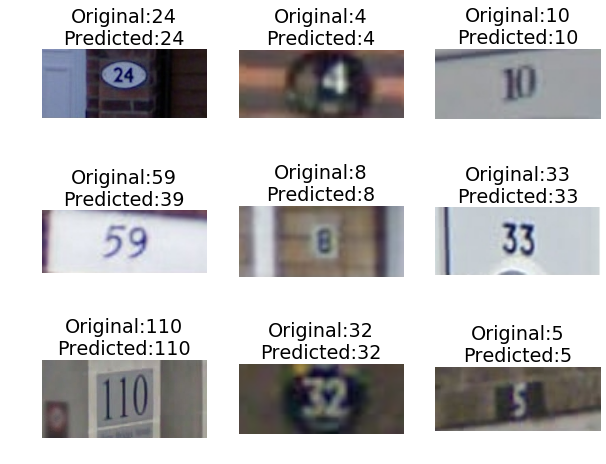

In [130]:
display_predicted_dataset(X_test, y_test_prediction, y_test)